# Integration of SVM and MVO 

A previous notebook attempted computational experiments with the following MIP formulation. 
$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 + \sum_{i=1}^N g(\xi_i)&\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R}, \quad \sum_i z_i \leq N \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon + \xi_i \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) + \epsilon - \xi_i \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N  \quad  w \in \mathbb{R}^m \quad \xi \geq 0& \\
\end{align} 
$$

with g as $C \xi/N$ where $C$ is a hyperparameter. It was found that directly solving the MIP above proved too computationally expensive. It would take over 24 hours to perform the ~20 years of monthly rebalancing experiments. The length of time required for a single MIP solve was also sensitive to the value of $m$. To address the computational expensiveness of solving the MIP in a  brute force fashion, I propose a penalized alternating direction method. 


## General Alternating Direction Methods 

####The description below is adapted primarily from "An Alternating Method for Cardinality-Constrained..." by Costa et. al. 

Consider the following problem:

$$
\begin{align} 
\min_{u, v} \quad & f(u, v)&\\ 
\textrm{s.t.} \quad & g(u,v) = 0, \quad h(u, v) \geq 0 \\
\quad & u \in \mathcal{U} \subseteq \mathbb{R}^{n_u}, \quad v \in \mathcal{V}  \subseteq \mathbb{R}^{n_v} \\
\end{align} 
$$

A standard alternating direction method (ADM) does the following:

1. Choose initial value $(u^0, v^0) \in \mathcal{U} \times \mathcal{V}$ and $l=0$
2. While not converged 

  2.1 Compute $u^{l+1} \in \text{argmin}\ \{  f(u,v^l): g(u, v^l) = 0, h(u,v^l) \geq 0, u \in \mathcal{U} \ \}$

  2.2 Compute $v^{l+1} \in \text{argmin}\ \{  f(u^{l+1},v): g(u^{l+1}, v) = 0, h(u^{l+1},v) \geq 0, v \in \mathcal{V} \ \}$

  2.3 $l \leftarrow l + 1$

Costa et al. then propose the use of a penalty function - variant of the ADM, whereby the coupling constraints induced by $h$ and $g$ are penalized in the objective as follows:

$$
\phi(u,v; \mu,  \rho) = f(u,v) + \sum_i \mu_i |g_i(u,v)| + \sum_j \rho_i [h_i(u,v)]^-
$$

where $\rho $ and $\mu$ denote the penalty parameters of the equality and inequality constraints. The penalized alternating direction method algorithm is nearly identical to the ADM; however, if the constraints are not satisfied at the end of the iterations, then the penalty parameters are increased, and the iteration is restarted. 

In the case of integrating support vector machines and mean-variance optimization, one formulation is as follows:

$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 &\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R}, \quad \sum_{i} z_i \leq N_l\\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon \quad & \forall i = 1,2,...,N  \ (A)\\
              \quad & -M(1-z_i) + \epsilon \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N\  (B)\\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N & \\
\end{align} 
$$
However, both constraints A and B can be replaced by the non-linear complementary constraint formulation:

$$(2 z_i - 1)(y_i^{\intercal} w + b) \geq \epsilon \quad i = 1,2,...,N$$

Although the constraint above is non-linear and non-convex, it decomposes into a simple linear constraint for each sub-problem when applying the alternating direction method.


Setting $u = (x, z)$ and $v = (w, b)$, the nominal problem becomes minimizing  $ f(u,v) = x^{\intercal} \Sigma x + \frac{1}{2} ||w||^2$ with 

$\mathcal{U} = \{(x,z) \in \mathbb{R}^N \times \{0,1\}^N \ | \ \mu^{\intercal} x \geq R,\  \mathbf{1}^{\intercal}x = 1,\  z_i= 1 \iff x_i > 0,\  \mathbf{1}^{\intercal} z \leq N_L \}$ 

and

 $\mathcal{V} = \{(w,b) \in \mathbb{R}^{m+1} \}$

and lastly, $h_i(u,v) = (2 z_i - 1)(y_i^{\intercal} w + b) - \epsilon$. Introducing the slack variables $\xi_i \geq 0 $ into the complementary constraint

$$(2 z_i - 1)(y_i^{\intercal} w + b) \geq \epsilon - \xi_i \quad i = 1,2,...,N$$

implies $[h_i(u,v)]^- = \xi_i(x, z, w, b)$ and that the penalty objective $\phi = x^{\intercal} \Sigma x + \frac{1}{2} ||w||^2 + \sum_{i} \mu_i \xi_i$ 

## Implementation ⌨

Given the previous iteration's SVM sub-problem results: ($w^l$, $b^l$), to obtain $x^{l+1}, z^{l+1}$ one solves $\min_{x, z}\ \{ x^{\intercal} \Sigma x  + \sum_{i} \mu_i \xi_i : \ \xi_i \geq 1 - (2z_i - 1)(y^{\intercal}w^{l} + b^l),\  (x, z) \in \mathcal{U} \ \}$

After computing $x^{l+1}, z^{l+1}$  it follows that $w^{l+1}, b^{l+1}$ are computed by solving $\min_{w, b}\ \{ \frac{1}{2} || w||^2 +  \sum_{i} \mu_i \xi_i : \ \xi_i \geq 1 - (2z^{l+1}_i - 1)(y^{\intercal}w + b),\  (w, b) \in \mathcal{V} \ \}$

In the implementation in this notebook, $\mu_i = C/N$ for a "large" C and the outer loop of incrementally increasing $\mu_i$ is not included. This is because it is possible that for a given return constraint, there may exist no portfolios with a support vector that linearly separates the assets. Therefore a significant preference for linearly separable portfolios should suffice. Furthermore, the two subproblems defined above avoid big M constraints, and are optimized more simply than the full formulation.

## Results from this notebook ⚡

* ADM method solves the min variance integrated SVM problem in approx 2.5 seconds, whereas the exact branch and bound MIP solver takes approx. 240 seconds for N = 286 assets and m = 3 factors used for the SVM decision boundary.
* The two solution methods have a max difference between the resulting portfolios of approximately 3%


In [1]:

pth = ''
import sys
import math

sys.path.append(pth + 'SVM MVO/PYFILES/')
from python.packages import *
from python.svm_mvo import *
from python.analysis_tools import *
import matplotlib
%matplotlib inline

## Import Forecasts
forecasts = pd.read_pickle(pth + 'cache/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'cache/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'cache/WRDS_ASOF.pkl')
## Import monthly prices
prices = pd.read_pickle(pth + 'cache/PRICES.pkl')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-09


In [2]:
mth = rets.index[0]
mth

Timestamp('2000-07-01 00:00:00')

In [3]:
#preprocessing
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N] + np.min(np.linalg.eigvals(cov_[:N,:N]))*np.eye(N)
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)
#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
#restrict the wharton research data to the columns of interest

#restrict the wharton research data to the columns of interest
Y = wrds_tics.loc[:,"ROC1":"Vol"] # Y matrix in formulation as per the paper
Y_normalized =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
Y_normalized = Y_normalized.iloc[:,:]
#Y_normalized = Y_normalized[['ROC1', 'INV1', 'PRO1'	, 'GRW1', 'LEV1', 'LIQ1']]
#Y_normalized['momentum'] = mean
Y_normalized = Y_normalized[['LEV1', 'GRW1']]

ret_constr = -1 #no return constraint
soft_margin = 5000 #large preference for separation feasibility
cardinality_total = True #consider as % of total assets if true else consider as % of MVO cardinality
ratio = 0.8 #% of assets
epsilon = 1e-3 #epsilon hyper-parameter
non_negativity_setting = True #set the hyperplane to have a normal in the non-negative orthant
dpi_setting = 150

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

In [4]:
MVO_model = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y, asset_lim= None,
             svm_choice = (False, False), print_var_frntr= False, cardinality = False) #define an instance of the class
MVO_model.set_model() #set up the model
MVO_model.model.params.MIPGAP = 0.05
MVO_model.optimize() #find optimal solution

AssetLim = math.floor((MVO_model.x.x > 10**(-6)).sum()*ratio)
if cardinality_total:
    AssetLim = ratio*math.floor(N)
#
# MVO.asset_lim = AssetLim
# MVO.cardinality = True
# MVO.set_model() #set up the model
# MVO.model.params.MIPGAP = 0.05
# MVO.optimize() #find optimal solution

CCPO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y, asset_lim= AssetLim,
             svm_choice = (False, False), print_var_frntr= False, cardinality = True) #define an instance of the class
CCPO.set_model() #set up the model
CCPO.model.params.MIPGAP = 0.05
CCPO.optimize() #find optimal solution


print("Asset Limit", AssetLim)

Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2 rows, 572 columns and 572 nonzeros
Model fingerprint: 0x210a655e
Model has 41041 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 286 columns
Presolve time: 0.02s
Presolved: 2 rows, 286 columns, 572 nonzeros
Presolved model has 41041 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 285
 AA' NZ     : 4.104e+04
 Factor NZ  : 4.133e+04 (roughly 1 MB of memory)
 Factor Ops : 7.921e+06 (less than 1 second per iteration)
 Threads    : 4

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.4231161

### Mean Variance and SVM Joint Using Alternating Directions Method Class Definition

The SVM_MVO_ADM objective does not require feasibility. Where as the other algorithm SVM_MVO_ADM_v2 does a random perturbation if it stalls at an infeasible point. 

In [5]:
MVO_ = MVO(tics, mean, cov, ret_constr, Y_normalized, AssetLim, epsilon=epsilon)
SVM_ = SVM(tics, Y_normalized , soft_margin, non_neg = non_negativity_setting, epsilon=epsilon)
SVM_MVO_Fast = SVM_MVO_ADM(MVO_, SVM_, IterLim = 10, ParamLim = 20)
SVM_MVO_Fast.MVO_.model.params.MIPGap = 0.05 
SVM_MVO_Fast.MVO_.model.params.timelimit = 10
SVM_MVO_Fast.SVM_.model.params.timelimit = 60
SVM_MVO_Fast.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast.SVM_.model.params.OutputFlag = 0
start = time.time()
SVM_MVO_Fast.initialize_soln()
print("Initialization successful")
ws , xs, zs , xi_mvo, xi_svm, dt, objs_svm, objs_mvo, penalty_hist = SVM_MVO_Fast.solve_adm()
end = time.time()
print("Solution time", end - start)

Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 60
Initialization successful
partial min convergence
outer iteration  0
0.0095367431640625
partial min convergence
outer iteration  1
0.019073486328125
partial min convergence
outer iteration  2
0.03814697265625
partial min convergence
outer iteration  3
0.0762939453125
partial min convergence
outer iteration  4
0.152587890625
partial min convergence
outer iteration  5
0.30517578125
partial min convergence
outer iteration  6
0.6103515625
partial min convergence
outer iteration  7
1.220703125
partial min convergence
outer iteration  8
2.44140625
partial min convergence
outer iteration  9
4.8828125
partial min convergence
outer iteration  10
9.765625
partial min convergence
outer iteration  11
19.53125
partial min convergence
outer iteration  12
39.0625
partial min convergence
outer iteration  13
78.125
partial min convergence
outer iteration  14
156.25
partial min convergence
outer it

### ADM method with individual updates on the penalty parameters

In [6]:
np.max(ws)

0.05956292104784792

In [7]:
MVO_2 = MVO(tics, mean, cov, ret_constr, Y_normalized, AssetLim)
SVM_2 = SVM(tics, Y_normalized , soft_margin*np.ones_like(mean), non_neg = non_negativity_setting)

SVM_MVO_Fast_v2 = SVM_MVO_ADM_v2(MVO_2, SVM_2, IterLim = 10, ParamLim = 15)
SVM_MVO_Fast_v2.MVO_.model.params.MIPGap = 0.05 
SVM_MVO_Fast_v2.MVO_.model.params.timelimit = 10
SVM_MVO_Fast_v2.SVM_.model.params.timelimit = 60
SVM_MVO_Fast_v2.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast_v2.SVM_.model.params.OutputFlag = 0
start = time.time()
SVM_MVO_Fast_v2.initialize_soln()
ws_2, xs_2, zs_2 , xi_mvo_2, xi_svm_2, dt_2, objs_svm_2, objs_mvo_2 = SVM_MVO_Fast_v2.solve_adm()
end = time.time()
print("Solution time", end - start)

Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 60
Stalling at Infeasible Point
SVM  0.04618203193785929
MVO  0.04617764273357504
Stalling at Infeasible Point
SVM  0.018460432673097823
MVO  0.018460310853506332
Stalling at Infeasible Point
SVM  0.01297382012360694
MVO  0.012973013227279511
Stalling at Infeasible Point
SVM  0.006542749661358594
MVO  0.006542577722360039
Stalling at Infeasible Point
SVM  0.0033529770278501346
MVO  0.0033529576780688282
Stalling at Infeasible Point
SVM  0.0010525646220539704
MVO  0.001052542260435511
Stalling at Infeasible Point
SVM  0.0002186181025328919
MVO  0.00021861785358923483
ADM terminated with C =  [[ 161.85313768]
 [ 211.40001656]
 [ 161.85313768]
 [ 161.85313768]
 [ 161.85313768]
 [ 412.15896606]
 [ 161.85313768]
 [ 161.85313768]
 [ 161.85313768]
 [ 161.85313768]
 [ 161.85313768]
 [ 184.97501449]
 [ 276.11430734]
 [ 161.85313768]
 [ 360.63909531]
 [ 161.85313768]
 [ 184.97501449]
 [ 241.60

In [8]:
Y_normalized.iloc[92]

LEV1    0.191668
GRW1    0.314636
Name: ES, dtype: float64

In [9]:
SVM_MVO_Fast.w.x

array([0.03027239, 0.05956292])

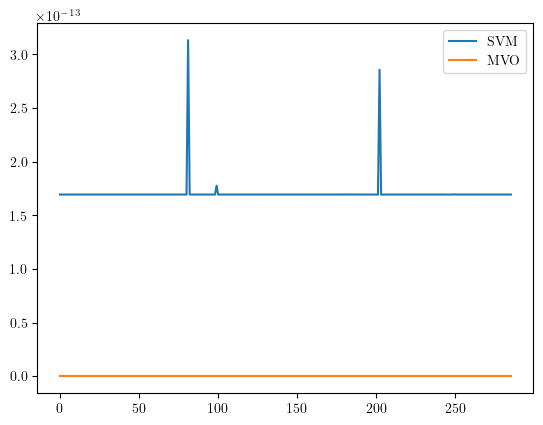

In [10]:
plt.plot(SVM_MVO_Fast.xi_svm.x, label = "SVM")
plt.plot(SVM_MVO_Fast.xi_mvo.x, label = "MVO")
plt.legend()

In [11]:
0.001*80000

80.0

In [12]:
sum(SVM_MVO_Fast.z.x)

226.0

In [13]:
SVM_MVO_Fast.xi_svm.x.sum()

4.8689474043296425e-11

In [14]:
SVM_MVO_Fast.xi_mvo.x.sum()

0.0

In [38]:
len(ws)

69

69


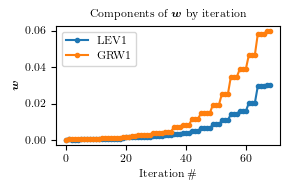

In [50]:
plt.figure(figsize = (3, 2))
plt.plot(ws , ".-")
plt.legend(Y_normalized.columns, fontsize = 8)
plt.xlabel("Iteration \#", fontsize = 8)
plt.ylabel(r"$\boldsymbol{w}$", fontsize = 8)
plt.title(r"Components of $ \boldsymbol{w}$ by iteration", fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig("Images/p4.svg",dpi = dpi_setting)
print(len(ws))

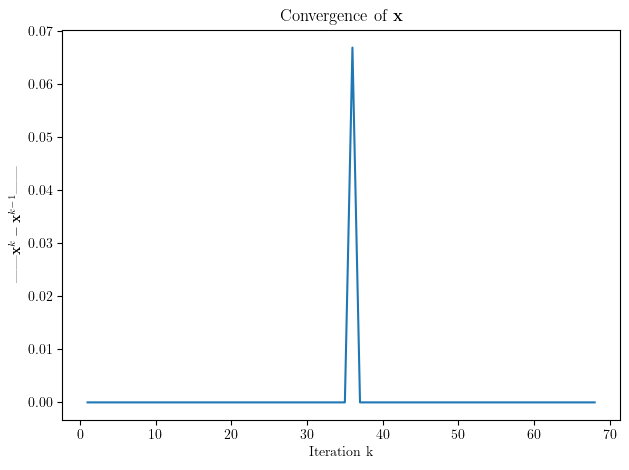

In [17]:
pd.DataFrame(xs).diff(\
                      ).abs().sum(axis = 1).iloc[1:].plot(xlabel = "Iteration k",\
                                                          ylabel = "||$\mathbf{x}^k - \mathbf{x}^{k-1}$||",\
                                                          title = "Convergence of $\mathbf{x}$");
plt.tight_layout()                                                                           
#plt.savefig("Images/p5.svg",dpi = dpi_setting)

xi for SVM as a function of iteration number
0     2.801385e-01
1     1.284931e-01
2     9.611013e-02
3     9.611013e-02
4     9.611013e-02
          ...     
64    4.190286e-05
65    4.190286e-05
66    4.190286e-05
67    4.868947e-11
68    4.868947e-11
Length: 69, dtype: float64
xi for MVO as a function of iteration number
0     0.000000
1     0.250006
2     0.093530
3     0.095984
4     0.095984
        ...   
64    0.000529
65    0.000042
66    0.000042
67    0.000042
68    0.000000
Length: 69, dtype: float64
These two series should converge to the same thing


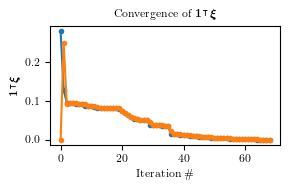

In [51]:
print("xi for SVM as a function of iteration number")
print(pd.DataFrame(xi_svm).sum(axis = 1))
print("xi for MVO as a function of iteration number")
print(pd.DataFrame(xi_mvo).sum(axis = 1))
print("These two series should converge to the same thing")
# plt.plot(xi_svm[:,:].sum(axis = 1), '.-');
# plt.plot(xi_mvo[:,:].sum(axis = 1), '.-');
plt.figure(figsize = (3,2))
plt.plot(np.arange(0, len(xi_svm[:,:])), xi_svm[0:,:].sum(axis = 1), '.-');
plt.plot(np.arange(0, len(xi_svm[:,:])), xi_mvo[0:,:].sum(axis = 1), '.-');
plt.xlabel("Iteration \#", fontsize = 8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel(r"$\boldsymbol{1}^{\intercal} \boldsymbol{\xi}$", fontsize = 8)
plt.title(r"Convergence of $\boldsymbol{1}^{\intercal} \boldsymbol{\xi}$", fontsize = 8)
plt.tight_layout()
plt.savefig("Images/p5_2.svg",dpi = dpi_setting)

xi for SVM as a function of iteration number
0     2.801385e-01
1     1.284931e-01
2     9.611013e-02
3     9.611013e-02
4     9.611013e-02
          ...     
64    4.190286e-05
65    4.190286e-05
66    4.190286e-05
67    4.868947e-11
68    4.868947e-11
Length: 69, dtype: float64
xi for MVO as a function of iteration number
0     0.000000
1     0.250006
2     0.093530
3     0.095984
4     0.095984
        ...   
64    0.000529
65    0.000042
66    0.000042
67    0.000042
68    0.000000
Length: 69, dtype: float64
These two series should converge to the same thing


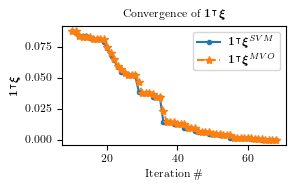

In [52]:

n_obs = 10
plt.figure(figsize = (3,2))
print("xi for SVM as a function of iteration number")
print(pd.DataFrame(xi_svm).sum(axis = 1))
print("xi for MVO as a function of iteration number")
print(pd.DataFrame(xi_mvo).sum(axis = 1))
print("These two series should converge to the same thing")
# plt.plot(xi_svm[:,:].sum(axis = 1), '.-');
# plt.plot(xi_mvo[:,:].sum(axis = 1), '.-');
plt.plot(np.arange(n_obs, len(xi_svm[:,:])), xi_svm[n_obs:,:].sum(axis = 1), '.-',
         label = r"$\boldsymbol{1}^{\intercal} \boldsymbol{\xi}^{SVM}$");
plt.plot(np.arange(n_obs, len(xi_svm[:,:])), xi_mvo[n_obs:,:].sum(axis = 1), '*--',
         label = r"$\boldsymbol{1}^{\intercal} \boldsymbol{\xi}^{MVO}$");
plt.xlabel("Iteration \#", fontsize = 8)
plt.ylabel(r"$\boldsymbol{1}^{\intercal} \boldsymbol{\xi}$", fontsize = 8)
plt.title(r"Convergence of $\boldsymbol{1}^{\intercal} \boldsymbol{\xi}$", fontsize = 8);
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(fontsize = 8)
plt.tight_layout()
plt.savefig("Images/p5_2.svg",dpi = dpi_setting)

In [20]:
#is there non separability
#check the last iteration xis
xi_mvo_2[-1][xi_mvo_2[-1] > 0.0001]

array([], dtype=float64)

In [21]:
#what is the asset allocation for non separable xi
xs_2[-1][xi_mvo_2[-1] > 0.0001]

array([], dtype=float64)

In [22]:
#which side of the hyperplane are the non separable points on. 
np.dot(Y_normalized.values[xi_mvo_2[-1] > 10**(-6)], SVM_2.w.x)+ SVM_2.b.x

array([], dtype=float64)

##Exact MIP Solution with ADM Warm Start

In [23]:
#SVM with slack 
#beat 600 seconds
SVM_MVO_Slck = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_normalized, AssetLim, \
                      svm_choice = (True, True), print_var_frntr = False, indicator = True, non_neg = non_negativity_setting, epsilon  = epsilon)
starts = [SVM_MVO_Fast.x.x, SVM_MVO_Fast.z.x, SVM_MVO_Fast.w.x, SVM_MVO_Fast.b.x]
SVM_MVO_Slck.model.params.FeasibilityTol = 1e-9
SVM_MVO_Slck.set_model(start = starts)
# SVM_MVO_Slck.model.params.Presolve = 2
# SVM_MVO_Slck.model.Params.ImpliedCuts = 2
SVM_MVO_Slck.optimize()

Set parameter FeasibilityTol to value 1e-09
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 290 rows, 1147 columns and 1716 nonzeros
Model fingerprint: 0xe5b91f05
Model has 41043 quadratic objective terms
Model has 572 general constraints
Variable types: 861 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
  GenCon rhs range [1e-03, 1e-03]
  GenCon coe range [2e-03, 1e+01]

User MIP start produced solution with objective 0.00292016 (0.05s)
Loaded user MIP start with objective 0.00292016

Presolve added 746 rows and 352 columns
Presolve time: 0.02s
Presolved: 1036 rows, 1499 columns, 4356 nonzeros
Presolved model has 462 SOS constraint(s)
Presolved model has 41043 quadratic objective terms
Variable types:

13.046931505203247

## Exact Solution without ADM

In [24]:
SVM_MVO_Slck.model.reset(clearall = 1)
SVM_MVO_Slck.set_model()
SVM_MVO_Slck.optimize()

Discarded solution information including additional information
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 290 rows, 1147 columns and 1716 nonzeros
Model fingerprint: 0x5b1a061e
Model has 41043 quadratic objective terms
Model has 1144 general constraints
Variable types: 861 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
  GenCon rhs range [1e-03, 1e-03]
  GenCon coe range [2e-03, 1e+01]
Presolve added 1384 rows and 990 columns
Presolve time: 0.03s
Presolved: 1674 rows, 2137 columns, 7018 nonzeros
Presolved model has 924 SOS constraint(s)
Presolved model has 41043 quadratic objective terms
Variable types: 1499 continuous, 638 integer (638 binary)
Found heuristic solution: objective 2.1130715

Root 

44.16681241989136

## Comparison between exact and ADM method

### Components of $w$

In [25]:
SVM_MVO_Slck.xi.x.sum()

0.0

In [26]:
SVM_MVO_Slck.z.x.sum()

226.0

In [27]:
SVM_MVO_Slck.b.x

array([0.00620327])

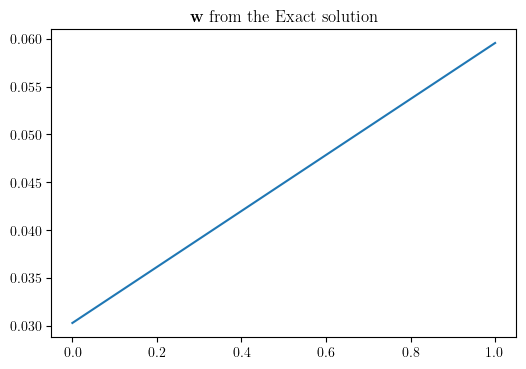

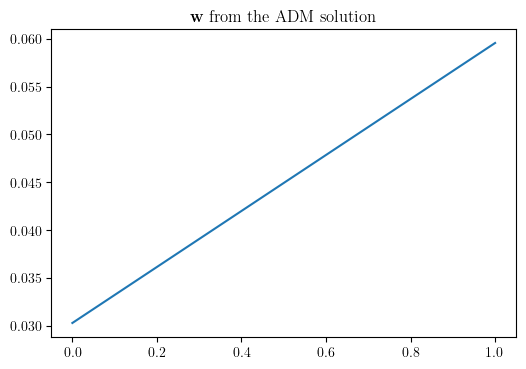

In [28]:
plt.figure(figsize = (6,4))
plt.plot(SVM_MVO_Slck.w.x)
plt.title("$\mathbf{w}$ from the Exact solution");

plt.figure(figsize = (6,4))
plt.plot(SVM_.w.x)
plt.title("$\mathbf{w}$ from the ADM solution");


In [29]:
### quick check for any mismatch between x > 0 and z = 1
# MVO_.x.x[(MVO_.x.x > 10**(-6)).astype(int) - MVO_.z.x > 0]

### Portfolio Comparison between exact and ADM method

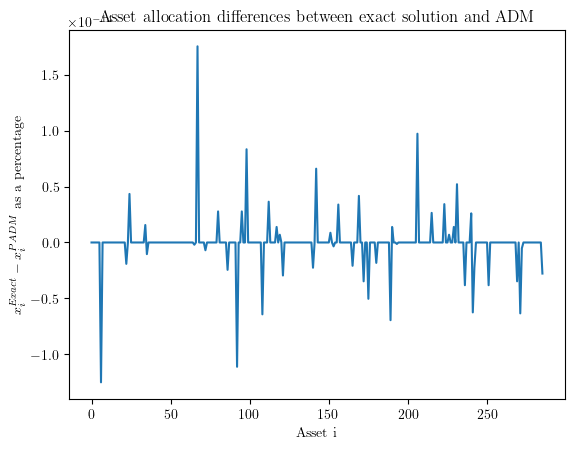

In [30]:
#plt.plot(MVO_.x.x)
plt.plot(100*(SVM_MVO_Slck.x.x - MVO_.x.x))
plt.xlabel("Asset i")
plt.ylabel("$x^{{Exact}}_i - x^{{PADM}}_i$ as a percentage");
plt.title("Asset allocation differences between exact solution and ADM");

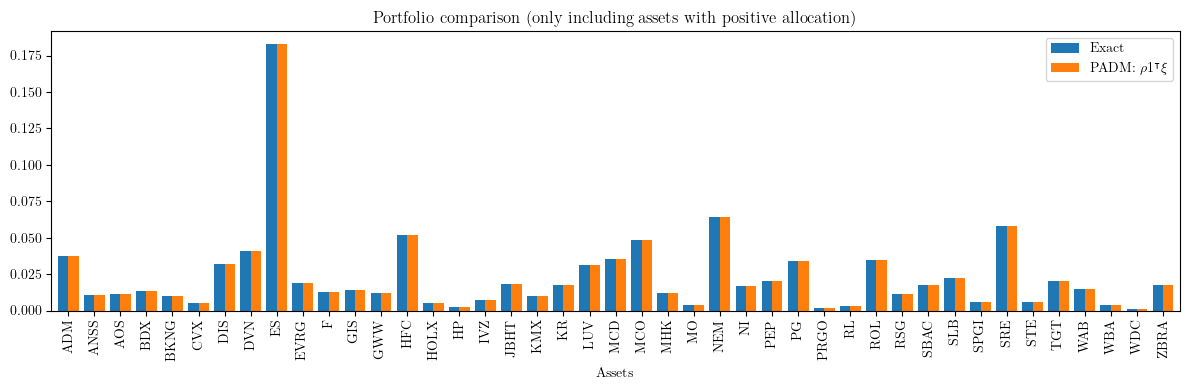

In [31]:
out = pd.concat([SVM_MVO_Slck.get_results(), SVM_MVO_Fast.get_results()], axis = 0)
out[out.columns[(out > 0.001).any(axis = 0)]].transpose()[:-2].plot.bar(title = 'Portfolio comparison (only including assets with positive allocation)',\
                                                                           xlabel = 'Assets', \
                                                                           ylabel = '% of Portfolio',\
                                                                           figsize = (12,4), width = 0.8);
plt.tight_layout()   
#plt.legend(["Exact", r"PADM: $\rho 1^{\intercal}\xi$", r"PADM: ${\bf \rho} ^{\intercal}\xi$"])                    
plt.legend(["Exact", r"PADM: $\rho 1^{\intercal}\xi$"])                                                                        

plt.savefig("Images/p5_5.svg",dpi = dpi_setting)